In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from figure_making import data_loader



## 1.1 Define the two candidate models: Bi-exponential & Exponentially Modified Gaussian (EMG)

### Basic models that define the steep rise and slower decay

#### 1. Bi-exponential Model

In [2]:
def bi_exponential(t, A, tau_rise, tau_decay):
    """
    Bi-exponential function.

    Models a transient signal with a fast rising phase and a slower decaying phase.
    This function represents the difference between two exponential processes and is
    frequently used to model synaptic currents, calcium transients, or
    neurotransmitter dynamics.

    Parameters:
    ----------
    t : array_like
        The independent variable (e.g., time), typically starting from 0.
    A : float
        The amplitude or scaling factor. It normalizes the function's peak to
        be proportional to this value. Must be positive.
    tau_rise : float
        The time constant of the rising phase. A smaller value results in a
        steeper rise. Must be positive.
    tau_decay : float
        The time constant of the decaying phase. A larger value results in a
        slower decay. Must be positive. For a typical transient shape,
        tau_decay should be greater than tau_rise.

    Returns:
    -------
    array_like
        The calculated bi-exponential values for each point in t.
    """
    # --- Input validation for robustness during fitting ---
    # The optimizer might test invalid parameter values. By returning np.inf,
    # we signal that this parameter combination is not allowed.
    if A <= 0 or tau_rise <= 0 or tau_decay <= 0:
        return np.inf

    # For a standard transient shape, the decay must be slower than the rise.
    # If tau_rise is greater than or equal to tau_decay, the function
    # will not produce a positive peak after t=0.
    if tau_rise >= tau_decay:
        return np.inf

    # --- Core calculation ---
    # The function is a difference of two exponentials.
    # The term with the smaller time constant (tau_rise) decays faster,
    # driving the initial part of the signal.
    rise_component = np.exp(-t / tau_rise)
    decay_component = np.exp(-t / tau_decay)

    # The difference between these two components creates the characteristic
    # rise-and-fall shape of the transient.
    return A * (decay_component - rise_component)

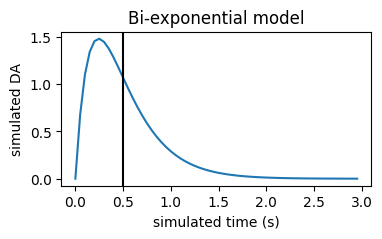

In [3]:
# simulate the bi-exponential model
tau_rise = 0.2 # Time it takes to rise to 63% of the peak; reasonable guess ranges between [0.1, 0.25]
tau_decay = 0.3 # reasonable guess between 1.0 to 1.2
A = 10 # A good starting guess would be 2 * observed_peak_height
t = np.arange(0, 3, 0.05)
simulated_DA = bi_exponential(t, A, tau_rise, tau_decay)
fig = plt.subplots(1,1,figsize=(4, 2))
plt.plot(t, simulated_DA)
plt.axvline(0.5, color='k')
plt.xlabel('simulated time (s)')
plt.ylabel('simulated DA')
plt.title('Bi-exponential model')
plt.show()

#### 2. Exponentially Modified Gaussian Model

In [4]:
from scipy.special import erfc # Import the complementary error function

def emg(x, A, mu, sigma, tau):
    """
    Exponentially Modified Gaussian (EMG) function.

    This function is the result of a convolution between a Gaussian function
    and an exponential decay function. It is often used for modeling
    asymmetric peaks.

    Parameters:
    ----------
    x : array_like
        The independent variable (e.g., time).
    A : float
        The amplitude or scaling factor. This is related to the area/height of the peak.
    mu : float
        The mean of the Gaussian component. It is closely related to the
        position of the peak's rising edge.
    sigma : float
        The standard deviation of the Gaussian component. It is related to the
        width or steepness of the rising edge. Must be positive.
    tau : float
        The time constant of the exponential decay component. It is related to
        the "tail" or skewness of the peak. Must be positive.

    Returns:
    -------
    array_like
        The calculated EMG values for each point in x.
    """
    # Ensure parameters that must be positive are handled gracefully.
    # curve_fit can sometimes test negative values.
    if sigma <= 0 or tau <= 0:
        return np.inf

    # The analytical solution for the EMG function
    term1 = (A / (2 * tau))
    term2 = np.exp((sigma**2 / (2 * tau**2)) - ((x - mu) / tau))
    term3 = erfc((sigma**2 - tau * (x - mu)) / (np.sqrt(2) * sigma * tau))

    return term1 * term2 * term3

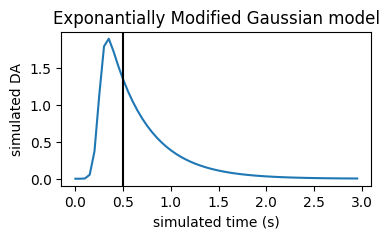

In [5]:
# simulate the EMG model
mu = 0.25 # the time at which it reaches its maximum
sigma = 0.05 # Std. Dev. of Gaussian; influences the steepness of the rising phase; reasonable range: 0.05 to 0.25
tau = 0.4 # controls the "tail" of the signal; reasonable range: 0.4 - 1.2
A = 1 # reasonable range 0.5 - 8
t = np.arange(0, 3, 0.05)
simulated_DA = emg(t, A, mu, sigma, tau)
fig = plt.subplots(1,1,figsize=(4, 2))
plt.plot(t, simulated_DA)
plt.axvline(0.5, color='k')
plt.xlabel('simulated time (s)')
plt.ylabel('simulated DA')
plt.title('Exponantially Modified Gaussian model')
plt.show()

### Add the refractory (shootdown) and the recovery phase by substracting an inverted Gaussian curve

In [6]:
def gaussian(t, A, mu, sigma):
    """A simple Gaussian function."""
    return A * np.exp(-(t - mu)**2 / (2 * sigma**2))

#### 1. Bi-exponential model with refractory period

In [7]:
def bi_exp_with_dip(t, A_transient, tau_rise, tau_decay, A_dip, mu_dip, sigma_dip):
    """
    Bi-exponential model combined with a negative Gaussian to model the refractory period
    Parameters:
    ----------
    t : array_like
        Independent variable (time).
    A_transient, tau_rise, tau_decay : float
        Parameters for the primary bi-exponential transient.
    A_dip, mu_dip, sigma_dip : float
        Parameters for the negative Gaussian dip.
        A_dip: Depth of the dip (positive value).
        mu_dip: Time of the dip's minimum point.
        sigma_dip: Duration/width of the dip
    """
    transient = bi_exponential(t, A_transient, tau_rise, tau_decay)
    dip = gaussian(t, A_dip, mu_dip, sigma_dip)

    return transient - dip

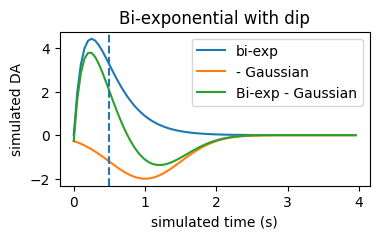

In [8]:
# simulate the model
tau_rise = 0.22 # Time it takes to rise to 63% of the peak; reasonable guess ranges between [0.1, 0.25]
tau_decay = 0.28 # reasonable guess between 1.0 to 1.2
A_transient = 50 # A good starting guess would be 2 * observed_peak_height
A_dip = 2 # lowest point
mu_dip = 1 # time of lowest point
sigma_dip = 0.5 # width of the inversed Gaussian
t = np.arange(0, 4, 0.05)
simulated_DA_dip = bi_exp_with_dip(t, A_transient, tau_rise, tau_decay, A_dip, mu_dip, sigma_dip)
simulated_DA_simple = bi_exponential(t, A_transient, tau_rise, tau_decay)

fig = plt.subplots(1,1,figsize=(4, 2))
plt.plot(t, simulated_DA_simple, label='bi-exp')
plt.plot(t, -gaussian(t, A_dip, mu_dip, sigma_dip), label='- Gaussian')
plt.plot(t, simulated_DA_dip, label='Bi-exp - Gaussian')
plt.axvline(0.5, linestyle='--')
plt.xlabel('simulated time (s)')
plt.xlabel('simulated time (s)')
plt.ylabel('simulated DA')
plt.legend()
plt.title('Bi-exponential with dip')
plt.show()

#### 2. Exponentially Modified Gaussian (EMG) model with refractory period

In [9]:
def emg_with_dip(t, A_transient, mu_transient, sigma_transient, tau_transient, A_dip, mu_dip, sigma_dip):
    """Exponentially Modified Gaussian (EMG) with a negative Gaussian dip.

    This model combines a primary EMG transient with a subsequent, negative-going
    Gaussian to capture signal undershoot dynamics.

    Parameters
    ----------
    t : array_like
        Independent variable (time).

    -- EMG Transient Parameters --
    A_transient : float
        Amplitude scaling factor for the transient.
    mu_transient : float
        Time position (mean) of the transient's Gaussian component.
    sigma_transient : float
        Width (std dev) of the transient's Gaussian component.
    tau_transient : float
        Skew (decay time) of the transient's exponential component.

    -- Gaussian Dip Parameters --
    A_dip : float
        Depth (amplitude) of the dip.
    mu_dip : float
        Time position (mean) of the dip's minimum point.
    sigma_dip : float
        Width (std dev) of the dip.

    Returns
    -------
    array_like
        The calculated composite signal.
    """

    transient = emg(t, A_transient, mu_transient, sigma_transient, tau_transient)
    dip = gaussian(t, A_dip, mu_dip, sigma_dip)
    return transient - dip

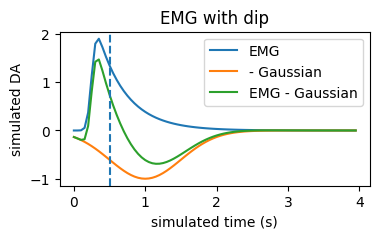

In [10]:
# simulate the emg_with_dip
mu = 0.25 # the time at which it reaches its maximum
sigma = 0.05 # Std. Dev. of Gaussian; influences the steepness of the rising phase; reasonable range: 0.05 to 0.25
tau = 0.4 # controls the "tail" of the signal; reasonable range: 0.4 - 1.2
A = 1 # reasonable range 0.5 - 8
A_dip = 1 # lowest point
mu_dip = 1 # time of lowest point
sigma_dip = 0.5
t = np.arange(0, 4, 0.05)

simulated_DA_simple = emg(t, A, mu, sigma, tau)
simulated_DA_dip = emg_with_dip(t, A, mu, sigma, tau, A_dip, mu_dip, sigma_dip)

fig = plt.subplots(1,1,figsize=(4, 2))
plt.plot(t, simulated_DA_simple, label='EMG')
plt.plot(t, -gaussian(t, A_dip, mu_dip, sigma_dip), label='- Gaussian')
plt.plot(t, simulated_DA_dip, label='EMG - Gaussian')
plt.axvline(0.5, linestyle='--')
plt.xlabel('simulated time (s)')
plt.xlabel('simulated time (s)')
plt.ylabel('simulated DA')
plt.legend()
plt.title('EMG with dip')
plt.show()

## 1.2 Find samples for fitting

### Read data from directory

In [11]:
animal_str = 'SZ036'
session_name = '2024-01-04T15_49'
zscore = data_loader.load_session_dataframe(animal_str, 'zscore',
                                                          session_long_name=session_name,
                                                          file_format='parquet')
trial_df = data_loader.load_session_dataframe(animal_str, 'trial_df', session_long_name=session_name,
                                              file_format='parquet')

Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-04T15_49_zscore.parquet
session: SZ036_2024-01-04
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-04T15_49_trial_df.parquet
session: SZ036_2024-01-04T1


### Find potential peaks in data

In [12]:
time = zscore['time_recording'].to_numpy()
signal = zscore['green_left'].to_numpy()
threshold = np.nanpercentile(signal, 90)
peaks, prop = find_peaks(signal, rel_height=0.25, width=[4, 40], height=threshold, wlen=60, prominence=1)

C:\Users\shich\AppData\Local\Temp\ipykernel_21348\2569949364.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


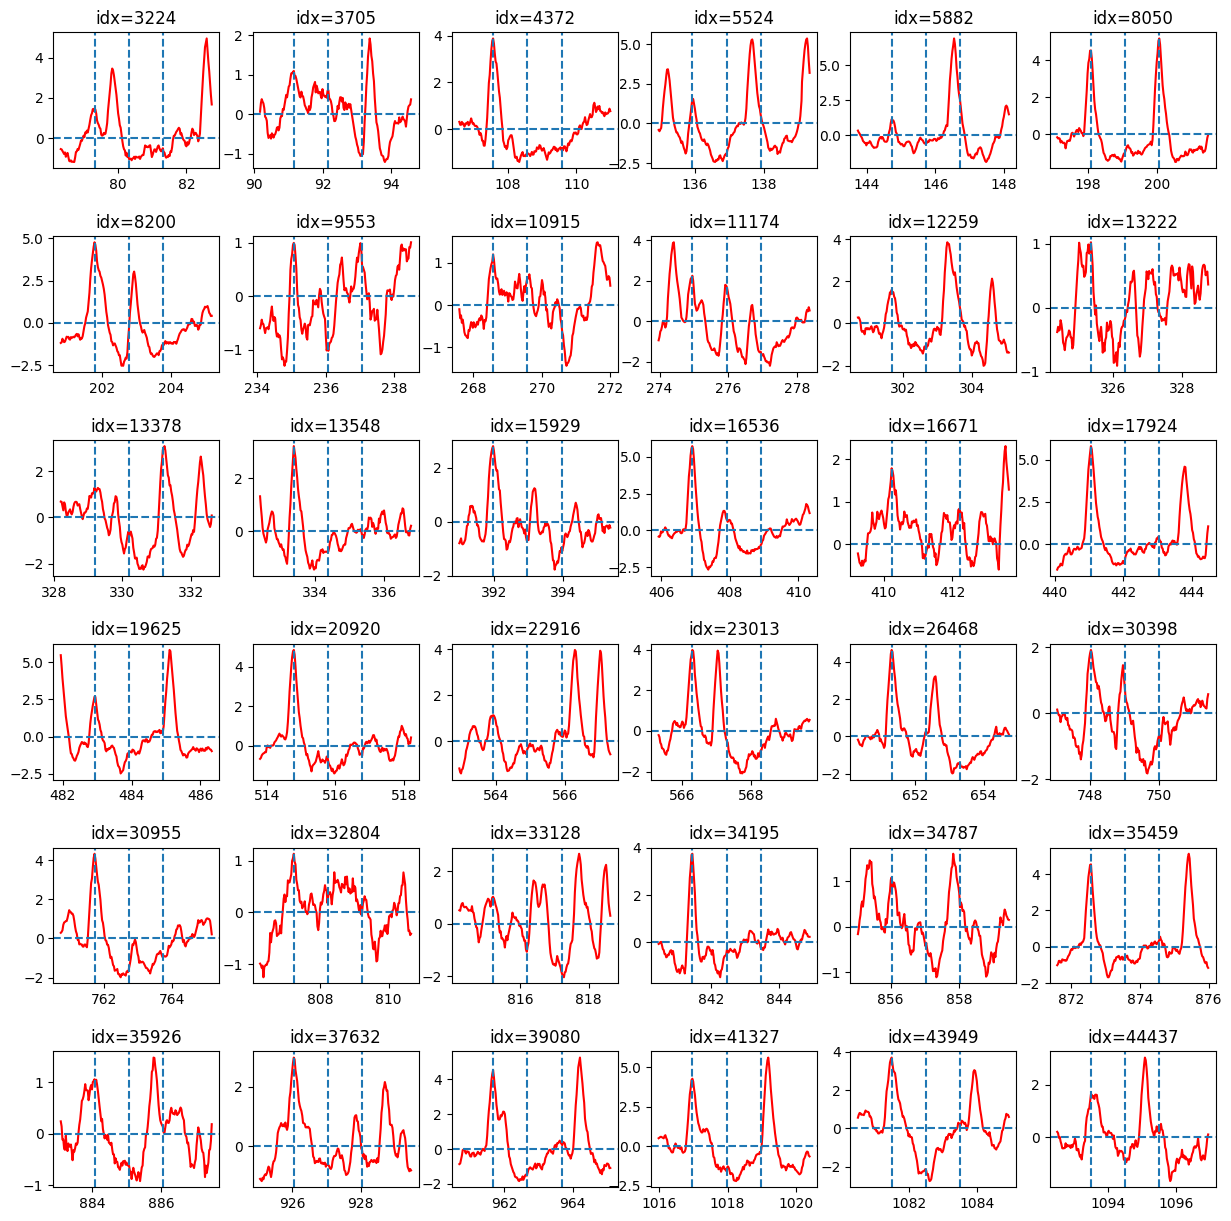

In [13]:
# plot random traces to know which samples to choose
pre = -40
post = 140
array_size = len(peaks)
array_indices = np.arange(array_size)
col_num = 6
row_num = 6
seed_value = 17
np.random.seed(seed_value)
randomly_selected_idx = np.sort(np.random.choice(peaks, size=row_num * col_num, replace=False))
fig, ax = plt.subplots(row_num, col_num, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
ax = ax.flatten()
for i, idx in enumerate(randomly_selected_idx):
    l = idx + pre
    r = idx + post
    ax[i].plot(time[l:r], signal[l:r], color='red')
    ax[i].axvline(time[idx], linestyle='--')
    ax[i].axvline(time[idx] + 1, linestyle='--')
    ax[i].axvline(time[idx] + 2, linestyle='--')
    ax[i].axhline(0, linestyle='--')
    ax[i].set_title(f'idx={idx}')
fig.show()

## 1.3 Consolidate and isolate samples from different animals and sessions

In [14]:
# Define the time window to extract around each peak (in seconds)
PRE_PEAK_SEC = 0.8  # Time before the peak
POST_PEAK_SEC = 2 # Time after the peak

# List of all sessions and peak indices to process
sessions_to_process = [
    {
        'animal': 'SZ036', 'session': '2024-01-03T16_13', 'channel': 'green_left',
        'indices': [1193, 2078, 5343, 9735, 20072, 29279, 31667]
    },
    {
        'animal': 'SZ036', 'session': '2024-01-04T15_49', 'channel': 'green_left',
        'indices': [4372, 7469, 9205, 11582, 12490, 18845, 19911, 20211, 21891, 27388]
    },
    {
        'animal': 'SZ036', 'session': '2024-01-08T13_52', 'channel': 'green_left',
        'indices': [12980, 15710, 22858, 31156, 35933, 37108, 43709]
    },
    {
        'animal': 'SZ037', 'session': '2024-01-12T10_36', 'channel': 'green_left',
        'indices': [34443]
    },
    {
        'animal': 'SZ043', 'session': '2023-12-11T20_42', 'channel': 'green_right',
        'indices': [7947, 12621, 20483, 33330, 44625]
    },
    {
        'animal': 'SZ043', 'session': '2023-12-13T18_44', 'channel': 'green_right',
        'indices': [231, 3148, 29182, 42919]
    },
    {
        'animal': 'SZ043', 'session': '2023-12-15T12_03', 'channel': 'green_right',
        'indices': [9021, 17560, 32095, 34858, 38169]
    }
]

In [15]:
all_peak_windows = []

for session_info in sessions_to_process:
    animal = session_info['animal']
    session = session_info['session']
    channel = session_info['channel']
    indices = session_info['indices']
    print(f"Processing {animal} / {session}...")
    zscore = data_loader.load_session_dataframe(animal, 'zscore',
                                                session_long_name=session,
                                                file_format='parquet')
    time_full = zscore['time_recording'].to_numpy()
    signal_full = zscore[channel].to_numpy()
    fs = 1 / 0.025
    pre_peak_idx = int(PRE_PEAK_SEC * fs)
    post_peak_idx = int(POST_PEAK_SEC * fs)
    for peak_idx in indices:
        start_idx = max(0, peak_idx - pre_peak_idx)
        end_idx = min(len(signal_full), peak_idx + post_peak_idx)
        time_window = time_full[start_idx:end_idx]
        signal_window = signal_full[start_idx:end_idx]
        time_window_normalized = time_window - time_window[0]
        peak_data = {
            'time': time_window_normalized,
            'signal': signal_window,
            'animal': animal,
            'session': session,
            'original_peak_index': peak_idx,
            'sampling_rate': fs
        }
        all_peak_windows.append(peak_data)

print(f"\nSuccessfully collected {len(all_peak_windows)} peak windows. Ready for fitting.")

Processing SZ036 / 2024-01-03T16_13...
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-03T16_13_zscore.parquet
session: SZ036_2024-01-03
Processing SZ036 / 2024-01-04T15_49...
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-04T15_49_zscore.parquet
session: SZ036_2024-01-04
Processing SZ036 / 2024-01-08T13_52...
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ036\processed_data\SZ036_2024-01-08T13_52_zscore.parquet
session: SZ036_2024-01-08
Processing SZ037 / 2024-01-12T10_36...
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLab\TemporalDecisionMaking\imaging_during_task\SZ037\processed_data\SZ037_2024-01-12T10_36_zscore.parquet
session: SZ037_2024-01-12
Processing SZ043 / 2023-12-11T20_42...
Loading: c:\Users\shich\OneDrive - Johns Hopkins\ShulerLa

## 1.4 Fitting

### Fitting with bi-exponential model

Fitting peak 1/39 from SZ036/2024-01-03T16_13


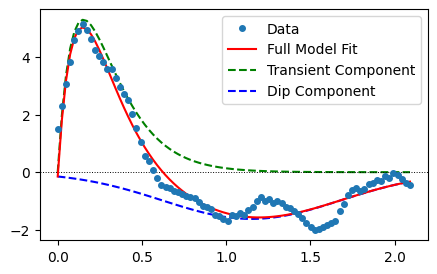

Fitting peak 2/39 from SZ036/2024-01-03T16_13


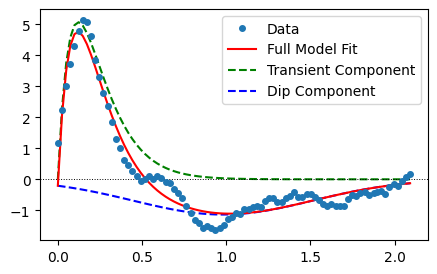

Fitting peak 3/39 from SZ036/2024-01-03T16_13


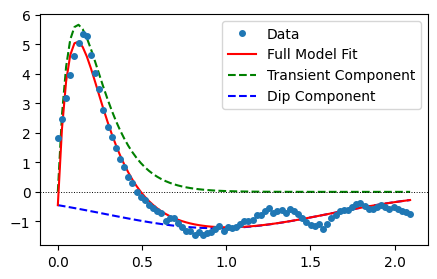

Fitting peak 4/39 from SZ036/2024-01-03T16_13


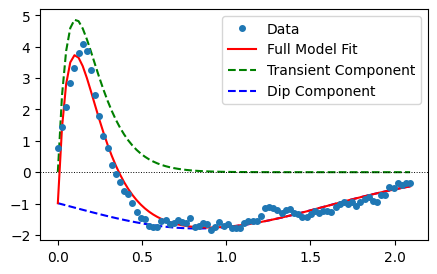

Fitting peak 5/39 from SZ036/2024-01-03T16_13


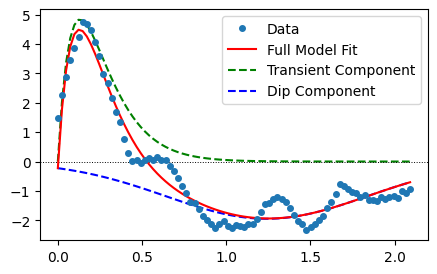

Fitting peak 6/39 from SZ036/2024-01-03T16_13


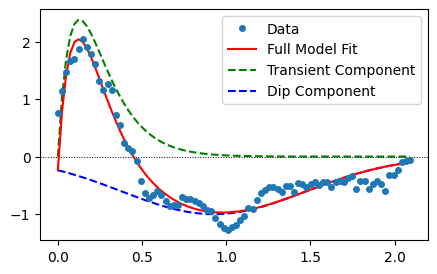

Fitting peak 7/39 from SZ036/2024-01-03T16_13


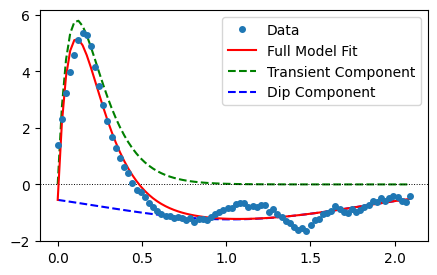

Fitting peak 8/39 from SZ036/2024-01-04T15_49


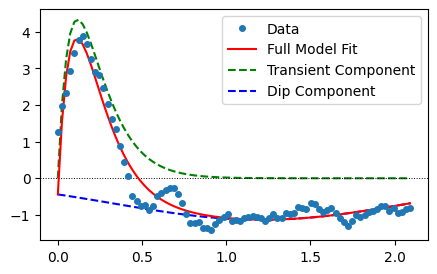

Fitting peak 9/39 from SZ036/2024-01-04T15_49


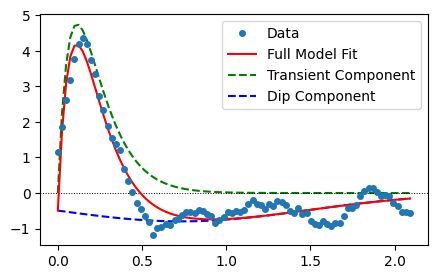

Fitting peak 10/39 from SZ036/2024-01-04T15_49


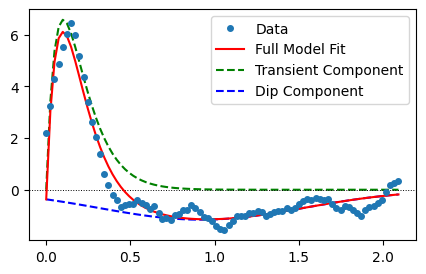

Fitting peak 11/39 from SZ036/2024-01-04T15_49


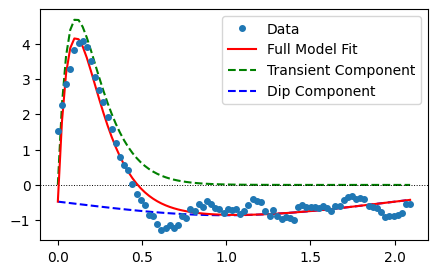

Fitting peak 12/39 from SZ036/2024-01-04T15_49
Fitting failed. Try adjusting initial guesses.
Fitting peak 13/39 from SZ036/2024-01-04T15_49
Fitting failed. Try adjusting initial guesses.
Fitting peak 14/39 from SZ036/2024-01-04T15_49


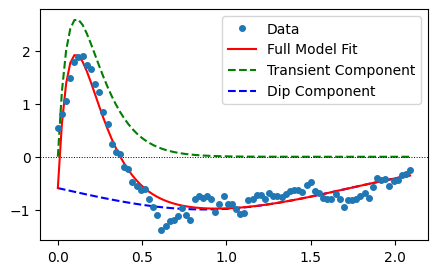

Fitting peak 15/39 from SZ036/2024-01-04T15_49


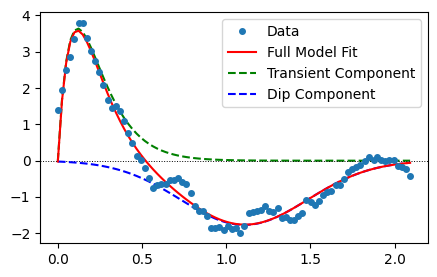

Fitting peak 16/39 from SZ036/2024-01-04T15_49
Fitting failed. Try adjusting initial guesses.
Fitting peak 17/39 from SZ036/2024-01-04T15_49


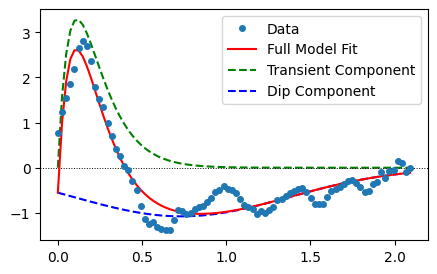

Fitting peak 18/39 from SZ036/2024-01-08T13_52
Fitting failed. Try adjusting initial guesses.
Fitting peak 19/39 from SZ036/2024-01-08T13_52


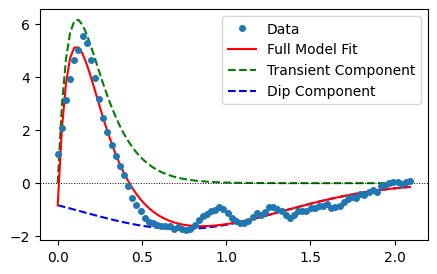

Fitting peak 20/39 from SZ036/2024-01-08T13_52


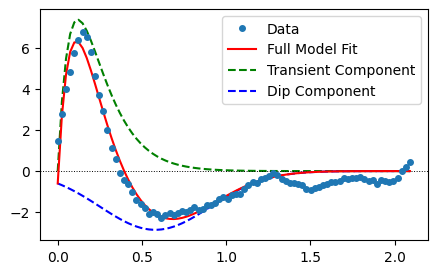

Fitting peak 21/39 from SZ036/2024-01-08T13_52


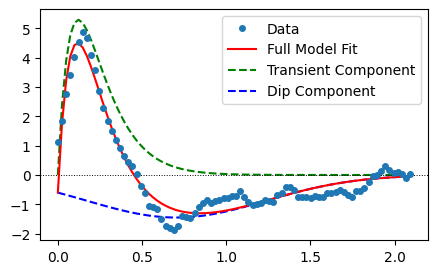

Fitting peak 22/39 from SZ036/2024-01-08T13_52


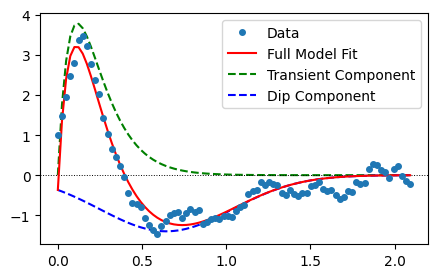

Fitting peak 23/39 from SZ036/2024-01-08T13_52


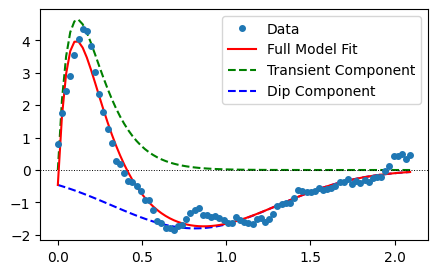

Fitting peak 24/39 from SZ036/2024-01-08T13_52


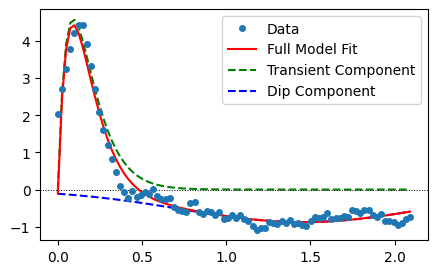

Fitting peak 25/39 from SZ037/2024-01-12T10_36


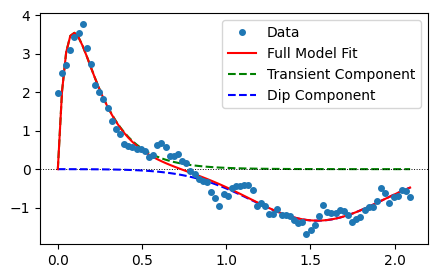

Fitting peak 26/39 from SZ043/2023-12-11T20_42


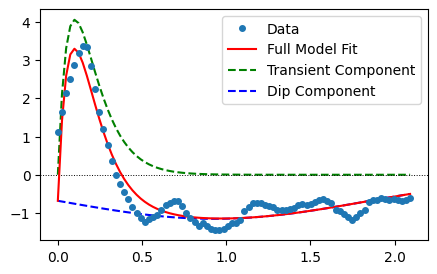

Fitting peak 27/39 from SZ043/2023-12-11T20_42


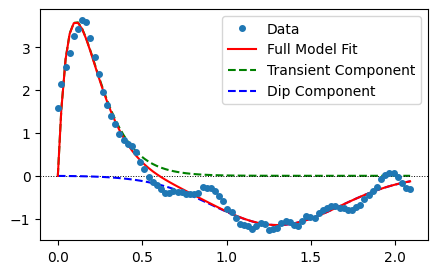

Fitting peak 28/39 from SZ043/2023-12-11T20_42


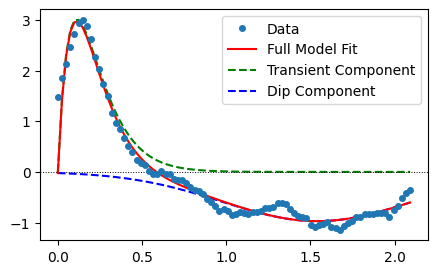

Fitting peak 29/39 from SZ043/2023-12-11T20_42


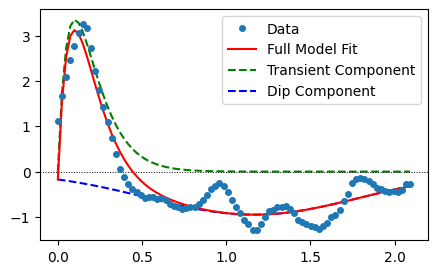

Fitting peak 30/39 from SZ043/2023-12-11T20_42


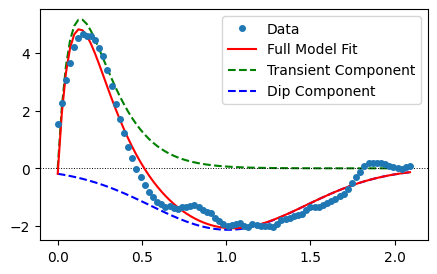

Fitting peak 31/39 from SZ043/2023-12-13T18_44


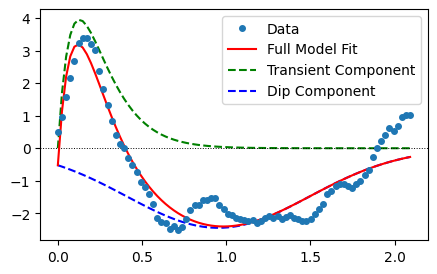

Fitting peak 32/39 from SZ043/2023-12-13T18_44


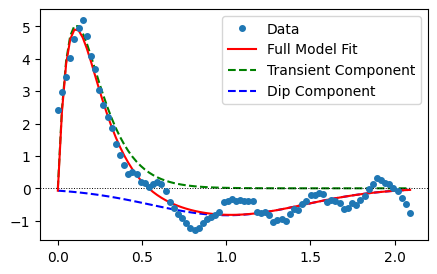

Fitting peak 33/39 from SZ043/2023-12-13T18_44


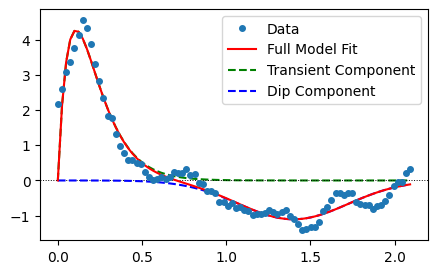

Fitting peak 34/39 from SZ043/2023-12-13T18_44


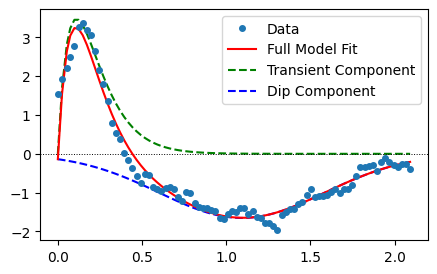

Fitting peak 35/39 from SZ043/2023-12-15T12_03


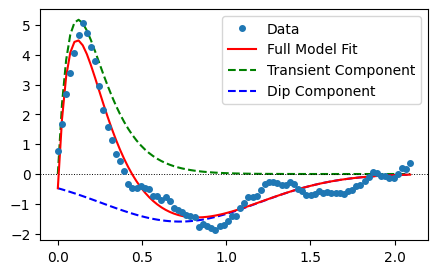

Fitting peak 36/39 from SZ043/2023-12-15T12_03


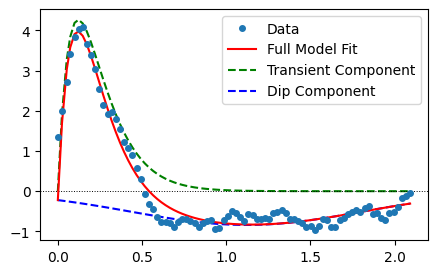

Fitting peak 37/39 from SZ043/2023-12-15T12_03


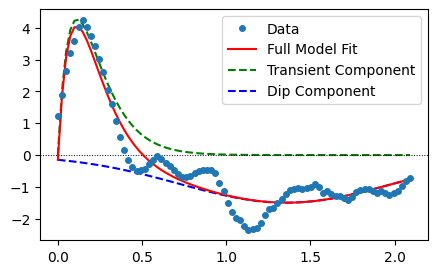

Fitting peak 38/39 from SZ043/2023-12-15T12_03


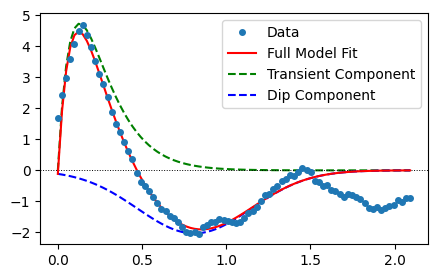

Fitting peak 39/39 from SZ043/2023-12-15T12_03


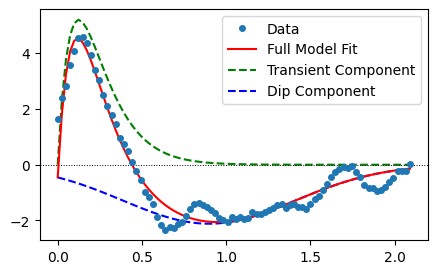

In [16]:
for i, peak_to_fit in enumerate(all_peak_windows):


    time_to_fit = peak_to_fit['time'][26:]
    time_to_fit = time_to_fit - time_to_fit[0]

    signal_to_fit = peak_to_fit['signal'][26:]

    print(f"Fitting peak {i+1}/{len(all_peak_windows)} from {peak_to_fit['animal']}/{peak_to_fit['session']}")

    # --- 1. Visually estimate the initial parameters ---
    peak_height = np.max(signal_to_fit)
    time_of_peak = time_to_fit[np.argmax(signal_to_fit)]

    dip_depth = np.abs(np.min(signal_to_fit))
    time_of_dip = time_to_fit[np.argmin(signal_to_fit)]

    # --- 2. Create the list of initial parameter guesses (p0) ---
    initial_guesses = [
        peak_height * 20,  # A_transient
        0.22,              # tau_rise
        0.28,              # tau_decay
        dip_depth,        # A_dip
        time_of_dip,      # mu_dip
        0.2               # sigma_dip (a reasonable guess for width)
    ]

    # --- 3. Define bounds to keep parameters physically plausible ---
    #    All parameters should be positive. mu_dip should occur after the main peak.
    lower_bounds = [0, 0, 0, 0, time_of_peak, 0]
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]

    # --- 4. Perform the fit ---

    try:
        params, _ = curve_fit(
            bi_exp_with_dip,
            time_to_fit,
            signal_to_fit,
            p0=initial_guesses,
            bounds=(lower_bounds, upper_bounds)
        )

        # Plot the result
        plt.figure(figsize=(5, 3))
        plt.plot(time_to_fit, signal_to_fit, 'o', label='Data', markersize=4, zorder=10)
        plt.plot(time_to_fit, bi_exp_with_dip(time_to_fit, *params), 'r-', label='Full Model Fit', zorder=9)

        # Optional: Plot individual components
        transient_fit = bi_exponential(time_to_fit, *params[:3])
        dip_fit = gaussian(time_to_fit, *params[3:])
        plt.plot(time_to_fit, transient_fit, 'g--', label='Transient Component', zorder=2)
        plt.plot(time_to_fit, -dip_fit, 'b--', label='Dip Component', zorder=3) # Plot as negative

        plt.axhline(0, color='black', linestyle=':', linewidth=0.7)
        plt.legend()
        plt.show()

    except RuntimeError:
        print("Fitting failed. Try adjusting initial guesses.")

### Fitting with EMG

Fitting peak 1/39 from SZ036/2024-01-03T16_13


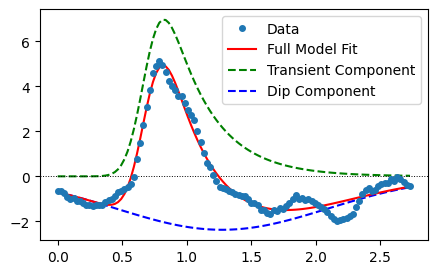

Fitting peak 2/39 from SZ036/2024-01-03T16_13


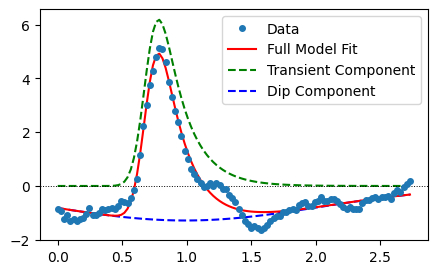

Fitting peak 3/39 from SZ036/2024-01-03T16_13


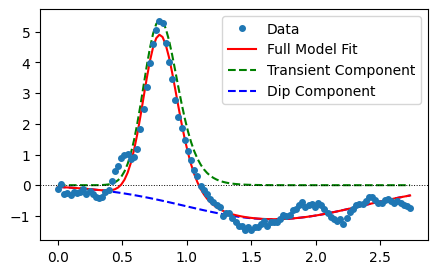

Fitting peak 4/39 from SZ036/2024-01-03T16_13


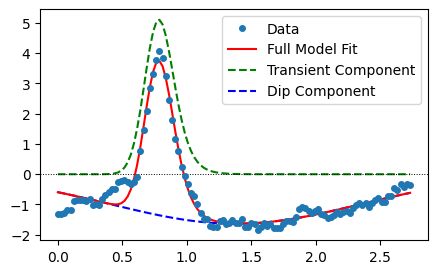

Fitting peak 5/39 from SZ036/2024-01-03T16_13


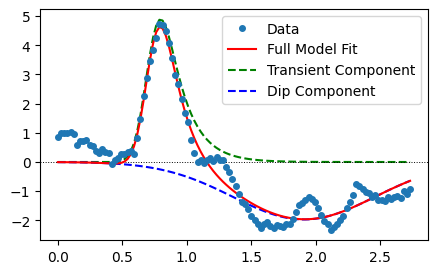

Fitting peak 6/39 from SZ036/2024-01-03T16_13


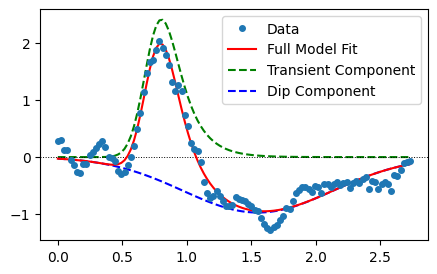

Fitting peak 7/39 from SZ036/2024-01-03T16_13


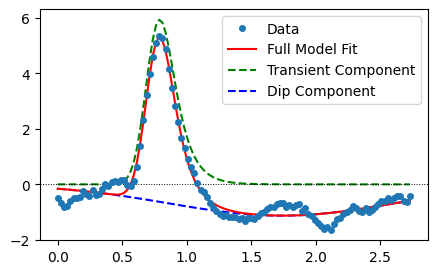

Fitting peak 8/39 from SZ036/2024-01-04T15_49


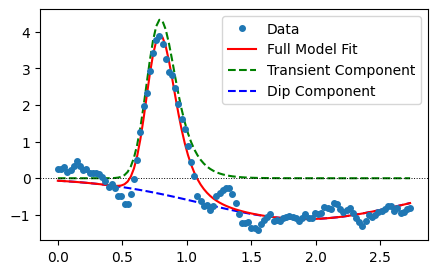

Fitting peak 9/39 from SZ036/2024-01-04T15_49


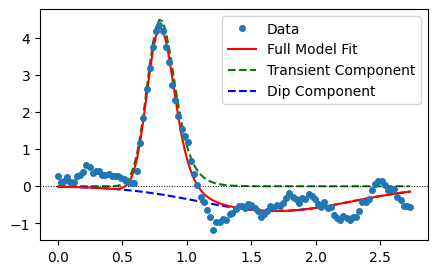

Fitting peak 10/39 from SZ036/2024-01-04T15_49


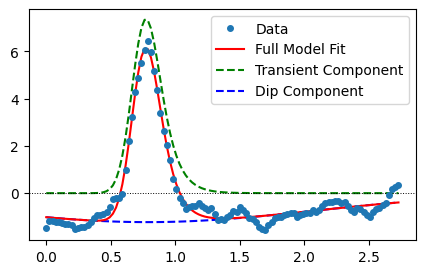

Fitting peak 11/39 from SZ036/2024-01-04T15_49


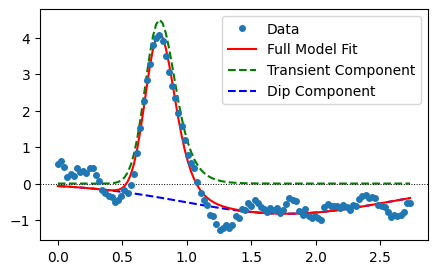

Fitting peak 12/39 from SZ036/2024-01-04T15_49


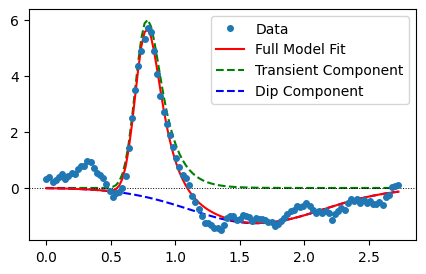

Fitting peak 13/39 from SZ036/2024-01-04T15_49


C:\Users\shich\AppData\Local\Temp\ipykernel_21348\159774460.py:39: RuntimeWarning: overflow encountered in exp
  term2 = np.exp((sigma**2 / (2 * tau**2)) - ((x - mu) / tau))
C:\Users\shich\AppData\Local\Temp\ipykernel_21348\159774460.py:42: RuntimeWarning: invalid value encountered in multiply
  return term1 * term2 * term3
C:\Users\shich\AppData\Local\Temp\ipykernel_21348\159774460.py:42: RuntimeWarning: overflow encountered in multiply
  return term1 * term2 * term3


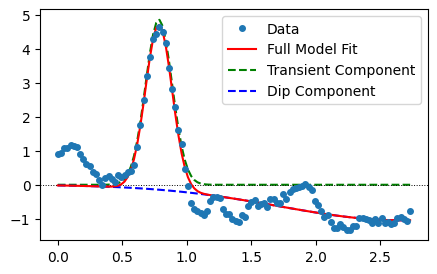

Fitting peak 14/39 from SZ036/2024-01-04T15_49


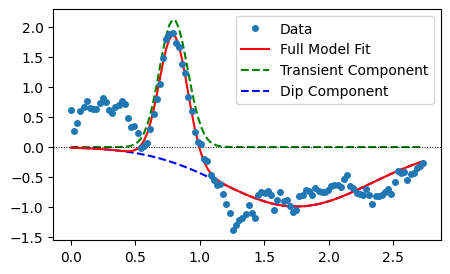

Fitting peak 15/39 from SZ036/2024-01-04T15_49


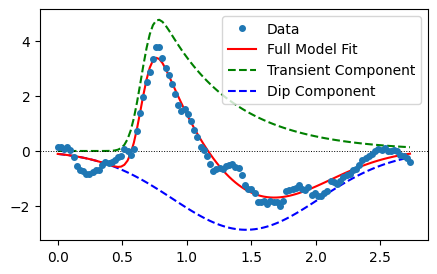

Fitting peak 16/39 from SZ036/2024-01-04T15_49


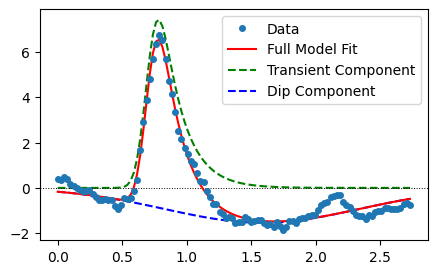

Fitting peak 17/39 from SZ036/2024-01-04T15_49


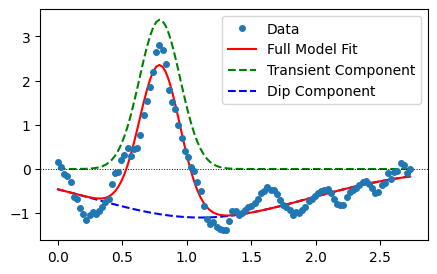

Fitting peak 18/39 from SZ036/2024-01-08T13_52


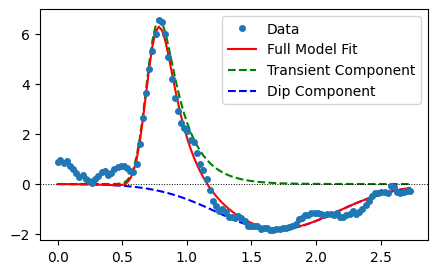

Fitting peak 19/39 from SZ036/2024-01-08T13_52


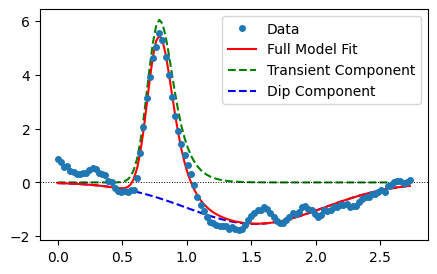

Fitting peak 20/39 from SZ036/2024-01-08T13_52


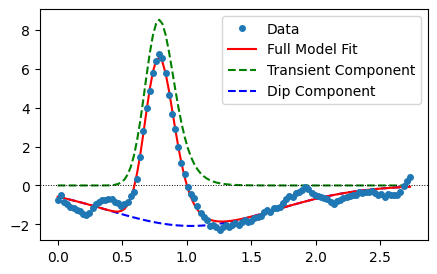

Fitting peak 21/39 from SZ036/2024-01-08T13_52


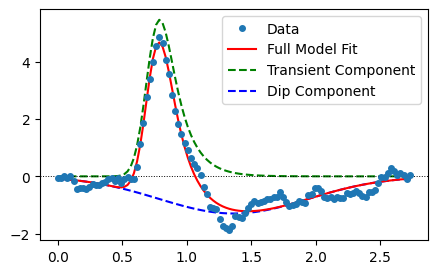

Fitting peak 22/39 from SZ036/2024-01-08T13_52


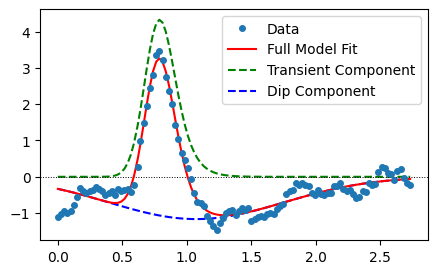

Fitting peak 23/39 from SZ036/2024-01-08T13_52


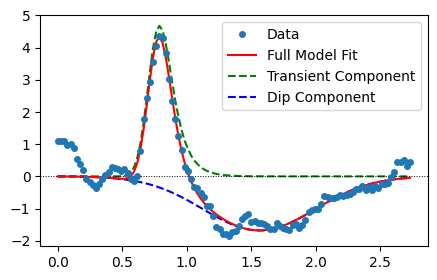

Fitting peak 24/39 from SZ036/2024-01-08T13_52


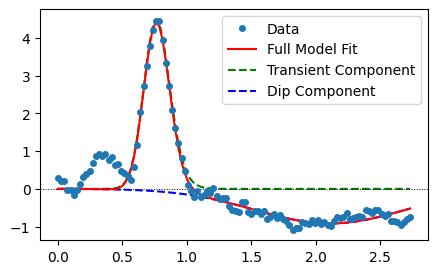

Fitting peak 25/39 from SZ037/2024-01-12T10_36


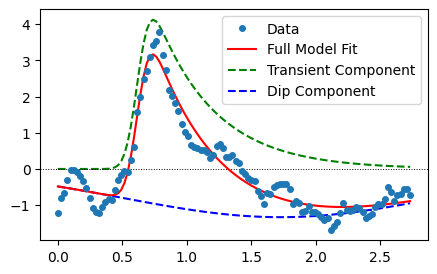

Fitting peak 26/39 from SZ043/2023-12-11T20_42


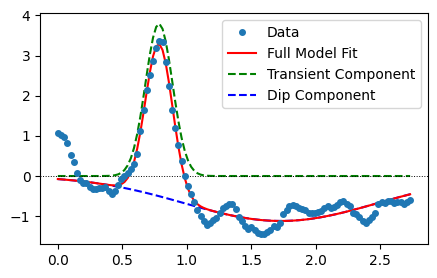

Fitting peak 27/39 from SZ043/2023-12-11T20_42


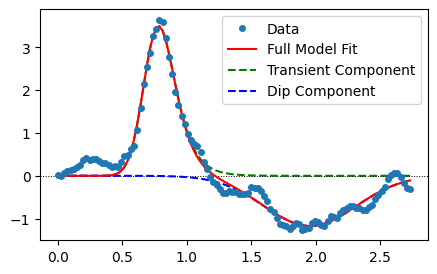

Fitting peak 28/39 from SZ043/2023-12-11T20_42


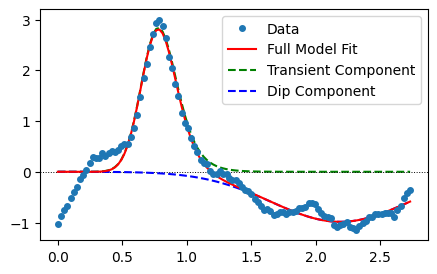

Fitting peak 29/39 from SZ043/2023-12-11T20_42


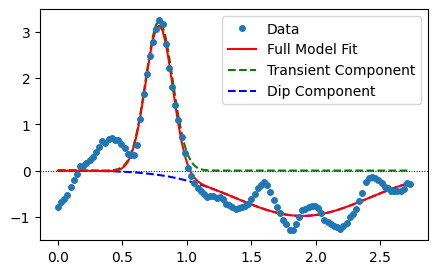

Fitting peak 30/39 from SZ043/2023-12-11T20_42


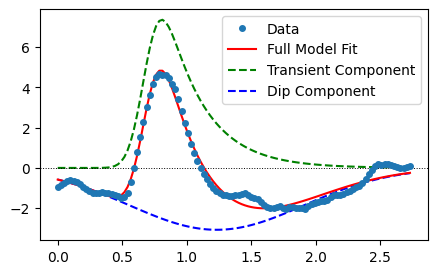

Fitting peak 31/39 from SZ043/2023-12-13T18_44
Fitting peak 32/39 from SZ043/2023-12-13T18_44


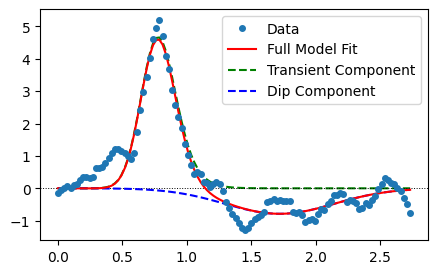

Fitting peak 33/39 from SZ043/2023-12-13T18_44


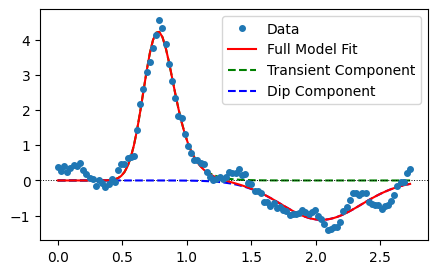

Fitting peak 34/39 from SZ043/2023-12-13T18_44


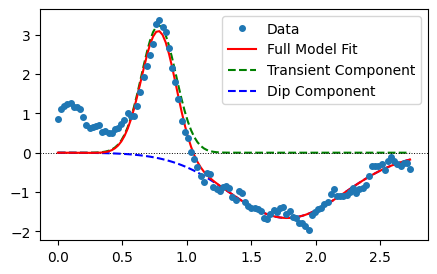

Fitting peak 35/39 from SZ043/2023-12-15T12_03


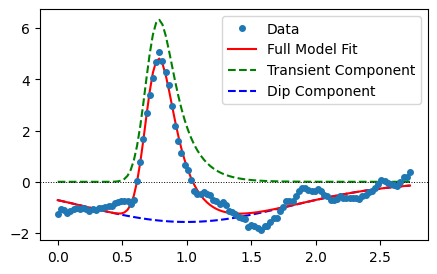

Fitting peak 36/39 from SZ043/2023-12-15T12_03
Fitting peak 37/39 from SZ043/2023-12-15T12_03


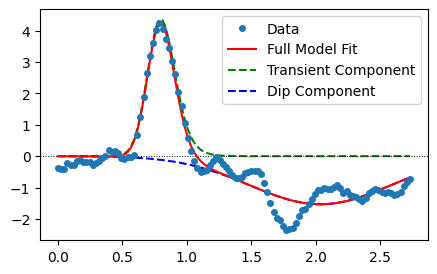

Fitting peak 38/39 from SZ043/2023-12-15T12_03


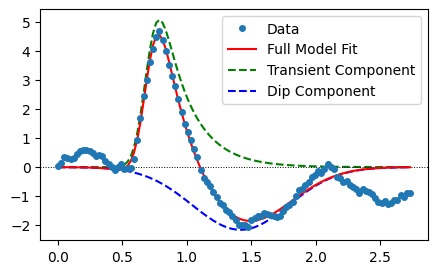

Fitting peak 39/39 from SZ043/2023-12-15T12_03


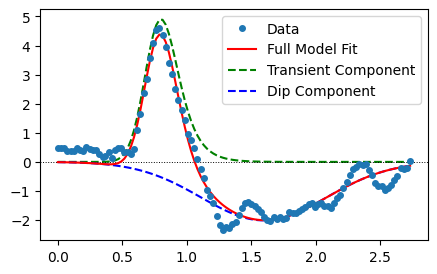

In [17]:
for i, peak_to_fit in enumerate(all_peak_windows):

    time_to_fit = peak_to_fit['time']
    signal_to_fit = peak_to_fit['signal']

    print(f"Fitting peak {i + 1}/{len(all_peak_windows)} from {peak_to_fit['animal']}/{peak_to_fit['session']}")

    # --- 1. Visually estimate the initial parameters ---
    peak_height = np.max(signal_to_fit)
    time_of_peak = time_to_fit[np.argmax(signal_to_fit)]

    dip_depth = np.abs(np.min(signal_to_fit))
    time_of_dip = time_to_fit[np.argmin(signal_to_fit)]

    # --- 2. Create the list of initial parameter guesses (p0) ---
    initial_guesses = [
        peak_height,  # A_transient
        time_of_peak, # mu_transient
        0.05,  # sigma_transient; Std. Dev. of Gaussian; the steepness of the rising phase; reasonable range: 0.05 to 0.25
        0.4,  # tau: controls the "tail" of the signal; reasonable range: 0.4 - 1.2
        dip_depth, # A_dip
        time_of_dip, # mu_dip
        0.2  # sigma_dip (a reasonable guess for width)
    ]

    # --- 3. Define bounds to keep parameters physically plausible ---
    #    All parameters should be positive. mu_dip should occur after the main peak.
    lower_bounds = [0, 0, 0, 0, 0, time_of_peak, 0]
    upper_bounds = [np.inf, 1, np.inf, np.inf, np.inf, np.inf, np.inf]

    # --- 4. Perform the fit ---

    try:
        params, _ = curve_fit(
            emg_with_dip,
            time_to_fit,
            signal_to_fit,
            p0=initial_guesses,
            bounds=(lower_bounds, upper_bounds)
        )

        # Plot the result
        plt.figure(figsize=(5, 3))
        plt.plot(time_to_fit, signal_to_fit, 'o', label='Data', markersize=4, zorder=10)
        plt.plot(time_to_fit, emg_with_dip(time_to_fit, *params), 'r-', label='Full Model Fit', zorder=9)

        # Optional: Plot individual components
        transient_fit = emg(time_to_fit, *params[:4])
        dip_fit = gaussian(time_to_fit, *params[4:])
        plt.plot(time_to_fit, transient_fit, 'g--', label='Transient Component', zorder=2)
        plt.plot(time_to_fit, -dip_fit, 'b--', label='Dip Component', zorder=3)  # Plot as negative

        plt.axhline(0, color='black', linestyle=':', linewidth=0.7)
        plt.legend()
        plt.show()

    except RuntimeError:
        print("Fitting failed. Try adjusting initial guesses.")

    except:
        continue

## 2.1 Aggregate and Sample Reward Instances